# 1. Setup

Install Dependencies

In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib
!pip install protobuf==3.20.*

Keyring is skipped due to an exception: 'keyring.backends'


Keyring is skipped due to an exception: 'keyring.backends'


 Import Dependencies

In [119]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from numpy import *
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

Set GPU Growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [9]:
# Find the paths
from pathlib import Path
print(Path.cwd())

C:\Users\ahmed


In [8]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# Collect Positives and Anchors

Untar Labelled Faces in the Wild Dataset

In [10]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
# go to "Download" and than download "All images as gzipped tar file" , after download it and place in the same path
#the name of the file we are gonna uncompress is "lfw.tgz"
!tar -xf lfw.tgz

In [11]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

Collect Positive and Anchor Classes

In [12]:
# Import uuid library to generate unique image names
import uuid

In [13]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\763756d8-9b66-11ed-9289-3ca0675cea1e.jpg'

In [14]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

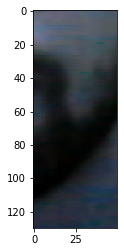

In [15]:
plt.imshow(frame[120:120+250,200:200+250, :])

# Data Augmentation

In [16]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [17]:
import os
import uuid

In [125]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [21]:
dir_test = anchor.as_numpy_iterator()


In [22]:
print(dir_test.next())

b'data\\anchor\\d1387086-9b67-11ed-87d0-3ca0675cea1e.jpg'


Preprocessing - Scale and Resize

In [23]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [ ]:
img = preprocess('data\\anchor\\b4ef3fca-9b67-11ed-87b9-3ca0675cea1e.jpg')


In [ ]:
img.numpy().max() 

In [ ]:
dataset.map(preprocess)

Create Labelled Dataset

In [29]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [30]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [31]:
samples = data.as_numpy_iterator()

In [32]:
exampple = samples.next()

In [33]:
exampple

(b'data\\anchor\\b588ee0c-9b67-11ed-b48a-3ca0675cea1e.jpg',
 b'data\\positive\\3fd3f2a2-9b68-11ed-a5e8-3ca0675cea1e.jpg',
 1.0)

Build Train and Test Partition

In [34]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [35]:
res = preprocess_twin(*exampple)

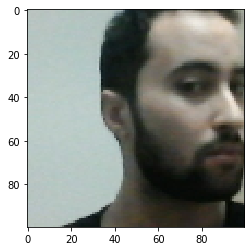

In [36]:
plt.imshow(res[1])

In [37]:
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7117647 , 0.7588235 , 0.74313724],
        [0.7171569 , 0.76029414, 0.74460787],
        [0.7286765 , 0.76593137, 0.7531863 ],
        ...,
        [0.59387255, 0.6213235 , 0.55269605],
        [0.6406863 , 0.66519606, 0.60833335],
        [0.64215684, 0.66568625, 0.6107843 ]],

       [[0.7235294 , 0.76960784, 0.75392157],
        [0.7289216 , 0.77156866, 0.7561275 ],
        [0.7345588 , 0.7713235 , 0.7588235 ],
        ...,
        [0.55710787, 0.5806373 , 0.52205884],
        [0.6215686 , 0.64215684, 0.5901961 ],
        [0.6509804 , 0.67156863, 0.6254902 ]],

       [[0.7264706 , 0.76960784, 0.75392157],
        [0.73014706, 0.7713235 , 0.75661767],
        [0.72843134, 0.7637255 , 0.7519608 ],
        ...,
        [0.4997549 , 0.5093137 , 0.4639706 ],
        [0.59313726, 0.6041667 , 0.5654412 ],
        [0.63039213, 0.64215684, 0.60490197]],

       ...,

       [[0.7343137 , 0.77254903, 0.7441176 ],
        [0.72

In [38]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [39]:
round(len(data))

622

In [40]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [41]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

Build Embedding Layer

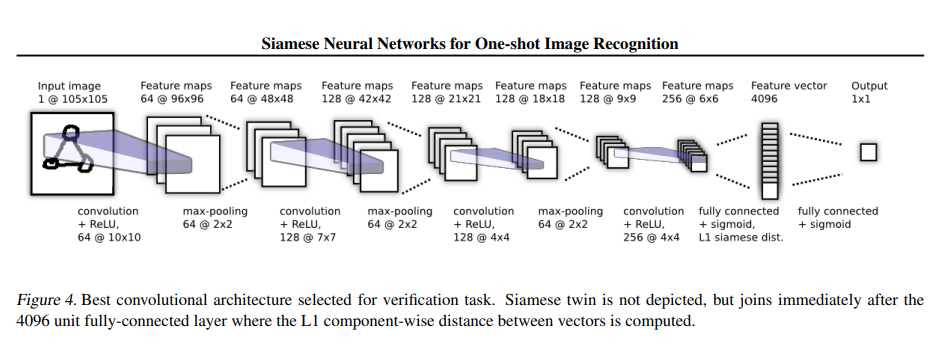

In [42]:
inp = Input(shape=(100,100,3), name='input_image')

In [43]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [44]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [45]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [46]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [47]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [48]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [49]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [50]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [51]:
embedding = make_embedding()

In [52]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

Build Distance Layer

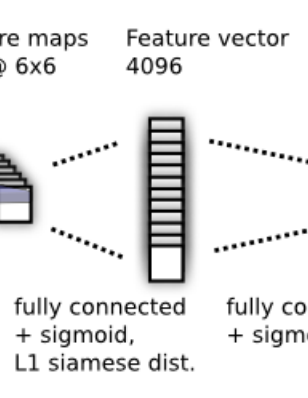

In [53]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [54]:
l1 = L1Dist()

In [55]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

Make Siamese Model

In [56]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [57]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [58]:
siamese_layer = L1Dist()


In [59]:
distances = siamese_layer(inp_embedding, val_embedding)


In [60]:
classifier = Dense(1, activation='sigmoid')(distances)


In [61]:
classifier


<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [62]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [63]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [64]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [65]:
siamese_model = make_siamese_model()

In [66]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training


In [67]:
#Setup Loss 
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [68]:
# Optimizer using ADam opyimaser method
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [69]:
#Establish Checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [70]:
test_batch = train_data.as_numpy_iterator()

In [71]:
batch_1 = test_batch.next()

In [72]:
X = batch_1[:2]

In [73]:
y = batch_1[2]

In [74]:
tf.losses.BinaryCrossentropy??

In [75]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [76]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [77]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [79]:
EPOCHS = 10

In [80]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
28/28 [==============================] - 615s 20s/step
0.01659379 0.91150445 0.91964287

 Epoch 2/10
28/28 [==============================] - 556s 20s/step
0.0013690889 0.9818182 1.0

 Epoch 3/10
28/28 [==============================] - 548s 20s/step
0.0318068 0.9953271 0.9953271

 Epoch 4/10
28/28 [==============================] - 543s 19s/step
0.005775587 0.9814815 1.0

 Epoch 5/10
28/28 [==============================] - 527s 19s/step
0.0004192354 0.9908257 0.9953917

 Epoch 6/10
28/28 [==============================] - 506s 18s/step
0.00047309298 0.9904762 0.9904762

 Epoch 7/10
28/28 [==============================] - 507s 18s/step
0.0007937272 0.9952153 0.9952153

 Epoch 8/10
28/28 [==============================] - 526s 19s/step
0.0013573384 0.99557525 1.0

 Epoch 9/10
28/28 [==============================] - 511s

# 6. Evaluate Model


# 

Import Metrics

In [81]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

Make Predictions

In [82]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [83]:
y_hat = siamese_model.predict([test_input, test_val])

In [84]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]

In [85]:
y_true

array([0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

Calculate Metrics

In [86]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [87]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [88]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 0.99


Viz Results

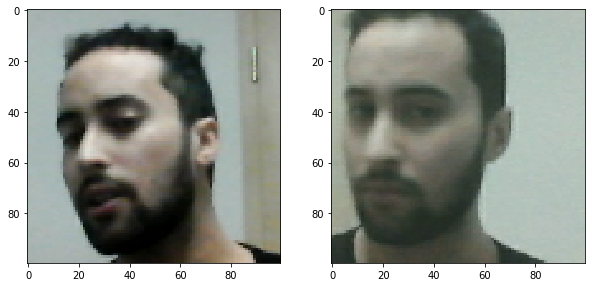

In [93]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[9])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[9])

# Renders cleanly
plt.show()

# 7. Save Model

In [94]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [95]:
L1Dist

__main__.L1Dist

In [96]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [97]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[2.2887866e-06],
       [2.1600723e-04],
       [9.9342453e-01],
       [9.9973464e-01],
       [9.9988687e-01],
       [9.6358854e-06],
       [4.3994188e-04],
       [1.6378348e-05],
       [1.8556595e-06],
       [9.9998856e-01],
       [3.5912672e-06]], dtype=float32)

In [98]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

Verification Function

In [99]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (<ipython-input-99-10b5f818160f>, line 1)

In [100]:
os.listdir(os.path.join('application_data', 'verification_images'))

['000ed328-9b68-11ed-bb66-3ca0675cea1e.jpg',
 '000fbc8c-9b68-11ed-9f4a-3ca0675cea1e.jpg',
 '00b29290-9b68-11ed-81ae-3ca0675cea1e.jpg',
 '00b30728-9b68-11ed-b33e-3ca0675cea1e.jpg',
 '00b35528-9b68-11ed-8b29-3ca0675cea1e.jpg',
 '00c3d7d4-9b68-11ed-99d8-3ca0675cea1e.jpg',
 '00c4c2b4-9b68-11ed-9c65-3ca0675cea1e.jpg',
 '00c511cc-9b68-11ed-9f1c-3ca0675cea1e.jpg',
 '00cab3de-9b68-11ed-af65-3ca0675cea1e.jpg',
 '00cb01dc-9b68-11ed-8651-3ca0675cea1e.jpg',
 '00d13c70-9b68-11ed-95ad-3ca0675cea1e.jpg',
 '00d18a7e-9b68-11ed-a0c5-3ca0675cea1e.jpg',
 '00d2263a-9b68-11ed-8a44-3ca0675cea1e.jpg',
 '00d2e912-9b68-11ed-9577-3ca0675cea1e.jpg',
 '00dde5b0-9b68-11ed-abb2-3ca0675cea1e.jpg',
 '0a02e7fe-9b68-11ed-aebc-3ca0675cea1e.jpg',
 '0a03d1ba-9b68-11ed-961e-3ca0675cea1e.jpg',
 '0a0e5dfe-9b68-11ed-98de-3ca0675cea1e.jpg',
 '0a0eee3e-9b68-11ed-84be-3ca0675cea1e.jpg',
 '0a14d13a-9b68-11ed-a708-3ca0675cea1e.jpg',
 '0a2e3b22-9b68-11ed-bbf0-3ca0675cea1e.jpg',
 '0a2eb002-9b68-11ed-96a7-3ca0675cea1e.jpg',
 '0a40cd24

In [101]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [102]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\000ed328-9b68-11ed-bb66-3ca0675cea1e.jpg
application_data\verification_images\000fbc8c-9b68-11ed-9f4a-3ca0675cea1e.jpg
application_data\verification_images\00b29290-9b68-11ed-81ae-3ca0675cea1e.jpg
application_data\verification_images\00b30728-9b68-11ed-b33e-3ca0675cea1e.jpg
application_data\verification_images\00b35528-9b68-11ed-8b29-3ca0675cea1e.jpg
application_data\verification_images\00c3d7d4-9b68-11ed-99d8-3ca0675cea1e.jpg
application_data\verification_images\00c4c2b4-9b68-11ed-9c65-3ca0675cea1e.jpg
application_data\verification_images\00c511cc-9b68-11ed-9f1c-3ca0675cea1e.jpg
application_data\verification_images\00cab3de-9b68-11ed-af65-3ca0675cea1e.jpg
application_data\verification_images\00cb01dc-9b68-11ed-8651-3ca0675cea1e.jpg
application_data\verification_images\00d13c70-9b68-11ed-95ad-3ca0675cea1e.jpg
application_data\verification_images\00d18a7e-9b68-11ed-a0c5-3ca0675cea1e.jpg
application_data\verification_images\00d2263a-9b68-11ed-8a44-3ca

In [103]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

OpenCV Real Time Verification

In [115]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
True


In [113]:
np.sum(np.squeeze(results) > 0.9)

95

In [114]:
results

[array([[0.98144644]], dtype=float32),
 array([[0.23511598]], dtype=float32),
 array([[0.9339701]], dtype=float32),
 array([[0.95660794]], dtype=float32),
 array([[0.9993949]], dtype=float32),
 array([[0.9913119]], dtype=float32),
 array([[0.03139648]], dtype=float32),
 array([[0.9975407]], dtype=float32),
 array([[0.31738588]], dtype=float32),
 array([[0.58645135]], dtype=float32),
 array([[0.84750366]], dtype=float32),
 array([[0.9197401]], dtype=float32),
 array([[0.99951226]], dtype=float32),
 array([[0.99959815]], dtype=float32),
 array([[0.9926517]], dtype=float32),
 array([[0.99960387]], dtype=float32),
 array([[0.9946462]], dtype=float32),
 array([[0.03132331]], dtype=float32),
 array([[0.29500163]], dtype=float32),
 array([[0.64902574]], dtype=float32),
 array([[0.99949896]], dtype=float32),
 array([[0.9895085]], dtype=float32),
 array([[0.9975552]], dtype=float32),
 array([[0.6595652]], dtype=float32),
 array([[0.8695216]], dtype=float32),
 array([[0.99967504]], dtype=float32